https://geoffboeing.com/2016/11/osmnx-python-street-networks/

In [1]:
%%capture

import os, tqdm
import pandas as pd
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points, transform
import pyproj
import heapq

# Configure OSMnx
ox.config(use_cache=True, log_console=True)

In [2]:
walking_speed = 1.22 # m/s
walking_speed = walking_speed * 60 # m/min

In [3]:
city_boxes = {'Rome': (41.9952, 41.7882, 12.6281, 12.3644), # north, south, east, west
              'Paris': (48.9520, 48.7650, 2.4900, 2.2100),
              'London': (51.6792, 51.2473, 0.2774, -0.4944)}

In [4]:
def get_subgraph(graph, bbox):

    north, south, east, west = bbox

    # List to hold nodes within the bbox
    nodes_within_bbox = []

    # Iterate over the nodes and their data in the graph
    for node, data in graph.nodes(data=True):
        # Check if the node is within the bbox
        if south <= data['y'] <= north and west <= data['x'] <= east:
            nodes_within_bbox.append(node)

    # List to hold edges where at least one end is within the bbox
    edges_within_bbox = []

    # Iterate over the edges in the graph
    for edge in graph.edges(keys=True,data=True):
        # If either of the nodes of the edge is in the nodes_within_bbox list, add the edge
        if edge[0] in nodes_within_bbox and edge[1] in nodes_within_bbox:
            edges_within_bbox.append(edge)

    # Create a subgraph with the edges within the bbox
    return graph.edge_subgraph([edge[:3] for edge in edges_within_bbox]).copy()

In [5]:
def explore(city, network_type, save):

    global city_boxes

    bbox = city_boxes[city.split(', ')[0]]

    # graph = ox.graph_from_place(city, network_type=network_type, simplify=True, retain_all=True, truncate_by_edge=True)
    # graph = ox.graph_from_point((45.39842, 11.87649), dist=150, network_type=network_type)
    graph = ox.graph_from_bbox(bbox = bbox, network_type=network_type)

    graph = ox.convert.to_undirected(graph)

    sub_graph = get_subgraph(graph, bbox = bbox)

    # Project graph
    graph = ox.projection.project_graph(graph, to_crs=3035)

    graph = ox.simplification.consolidate_intersections(
        # Graph to simplify
        graph,
        # buffer around each node (project the graph beforehand)
        tolerance=5,
        # Get result as graph (False to get nodes only as gdf)
        rebuild_graph=True,
        # no dead ends
        dead_ends=False,
        # Reconnect (False to get intersections only)
        reconnect_edges=True
    )

    if save:
        ox.plot_graph(sub_graph, bgcolor='w', node_size = 0, node_edgecolor='k', save=True, filepath=os.path.join('./images', city.split(', ')[0] + '.png'))
    else:
        ox.plot_graph(sub_graph, bgcolor='w', node_size = 0, node_edgecolor='k')

In [6]:
if False:
    explore('Rome, Italy', 'all', True)

In [7]:
city = 'Paris, France'
network_type = 'all'

In [8]:
bbox = city_boxes[city.split(', ')[0]]

In [9]:
# graph = ox.graph_from_place(city, network_type=network_type, simplify=True, retain_all=True, truncate_by_edge=True)
# graph = ox.graph_from_point((45.39842, 11.87649), dist=150, network_type=network_type)
graph = ox.graph_from_bbox(bbox = bbox, network_type=network_type)

# sub_graph = get_subgraph(graph, bbox = bbox)

# Project graph
graph = ox.projection.project_graph(graph, to_crs=3035)

graph = ox.simplification.consolidate_intersections(
    # Graph to simplify
    graph,
    # buffer around each node (project the graph beforehand)
    tolerance=5,
    # Get result as graph (False to get nodes only as gdf)
    rebuild_graph=True,
    # no dead ends
    dead_ends=False,
    # Reconnect (False to get intersections only)
    reconnect_edges=True
)

graph = ox.convert.to_undirected(graph)

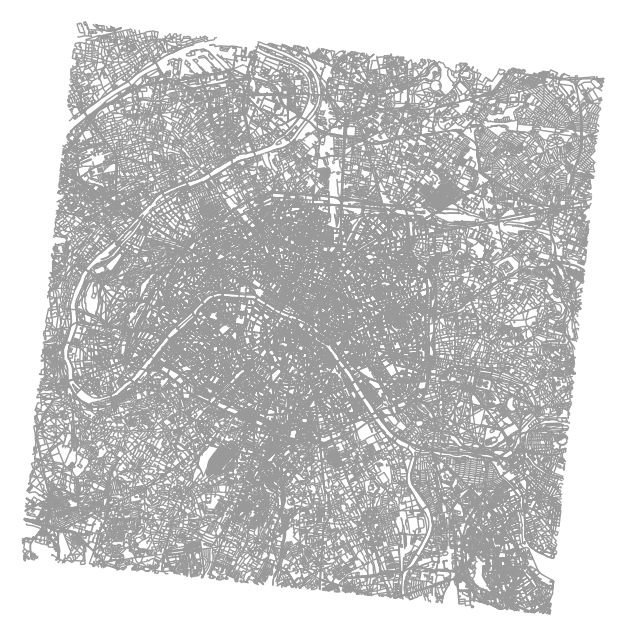

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:
ox.plot_graph(graph, bgcolor='w', node_size = 0, node_edgecolor='k')

In [11]:
%%capture
# https://wiki.openstreetmap.org/wiki/Key:amenity?uselang=en-GB

supermarket = ox.features.features_from_bbox(bbox = bbox, tags={'shop': ['supermarket','convenience']}).to_crs(epsg=3035)
pharmacy = ox.features.features_from_bbox(bbox = bbox, tags={'amenity': 'pharmacy'}).to_crs(epsg=3035)
cafe = ox.features.features_from_bbox(bbox = bbox, tags={'amenity': ['cafe', 'bar']}).to_crs(epsg=3035)

unique_services = ['supermarket', 'cafe', 'pharmacy']

In [12]:
service_nodes = dict([(unique_services[i],[]) for i in range(len(unique_services))])

_ = [print(k, len(eval(k))) for k, v in service_nodes.items()]

supermarket 3919
cafe 5147
pharmacy 1778


In [13]:
# Define a function to insert a service node into the graph
def insert_service_node(graph, service_type, service_lon, service_lat):
    
    # Find the nearest edge and get the geometry to the service location
    u, v, key = ox.nearest_edges(graph, X=service_lon, Y=service_lat) # (u, v have x, y coordinates)

    # Create a point for the service location
    point = Point(service_lon, service_lat) # (lon, lat)

    # If edge is not a straight line, i.e. contains a 'geometry'
    try:
        edge_geom = graph.edges[u, v, key]['geometry']
        edge_weight = edge_geom.length
        edge_weight_linear = (edge_geom.coords[0]).distance(edge_geom.coords[-1]) * 111320

    except:
        # Coordinates of the nearest_edges
        edge_geom = LineString([(graph.nodes[u]['x'], graph.nodes[u]['y']),(graph.nodes[v]['x'], graph.nodes[v]['y'])])
        edge_weight = edge_weight_linear = Point(graph.nodes[u]['x'], graph.nodes[u]['y']).distance(Point(graph.nodes[v]['x'], graph.nodes[v]['y'])) * 111320
        # edge_weight = line_string_distance(edge_geom)
        
    # Calculate the closest point on the edge to the service location
    closest_point_on_edge = nearest_points(edge_geom, point)[0] # (lon. lat)

    # Ratio of first segment to total length
    if closest_point_on_edge == Point(edge_geom.coords[0]):
        graph.nodes[u]['service_type'] = service_type
        return
    elif closest_point_on_edge == Point(edge_geom.coords[-1]):
        graph.nodes[v]['service_type'] = service_type
        return

    # Create new edges with the split geometries
    edge_geom_1 = LineString([edge_geom.coords[0], (closest_point_on_edge.x, closest_point_on_edge.y)])
    edge_geom_2 = LineString([(closest_point_on_edge.x, closest_point_on_edge.y), edge_geom.coords[-1]])

    # Insert the new node into the graph
    new_node_id = max(graph.nodes()) + 1  # or any unique ID
    graph.add_node(new_node_id, x=closest_point_on_edge.x, y=closest_point_on_edge.y, service_type=service_type)

    ratio_segment_1 = closest_point_on_edge.distance(Point(edge_geom.coords[0])) / edge_weight_linear

    # Split weight based on ratio
    # weight_segment_1 = line_string_distance(edge_geom_1)
    # weight_segment_2 = line_string_distance(edge_geom_2)
    weight_segment_1 = edge_weight * ratio_segment_1
    weight_segment_2 = edge_weight * (1 - ratio_segment_1)

    # # Remove the old edge and add the new edges
    graph.remove_edge(u, v)
    graph.add_edge(u, new_node_id, key=key, geometry=edge_geom_1, length=weight_segment_1)
    graph.add_edge(new_node_id, v, key=key, geometry=edge_geom_2, length=weight_segment_2)

    return new_node_id

In [14]:
# x = longitude, y = latitude

for s in tqdm.tqdm(unique_services):
    if 'node' in list(eval(s).index.get_level_values(0)):
        for v in eval(s)['geometry']['node'].get_coordinates().iterrows():
            node_id = insert_service_node(graph, s, v[1]['x'], v[1]['y'])
            if node_id is not None:
                service_nodes[s].append(node_id)
    if 'way' in list(eval(s).index.get_level_values(0)):
        for v in eval(s)['geometry']['way'].get_coordinates().groupby('osmid').agg('mean').iterrows():
            node_id = insert_service_node(graph, s, v[1]['x'], v[1]['y'])
            if node_id is not None:
                service_nodes[s].append(node_id)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/Marco/.pyenv/versions/3.12.0/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/Marco/.pyenv/versions/3.12.0/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/Marco/.pyenv/versions/3.12.0/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/Marco/.pyenv/versions/3.12.0/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/Marco/.pyenv/versions/3.12.0/lib/python3.12/site-packages/shapely/linear.py:203: RuntimeWarning: invalid value encountered in shortest_line
  return lib.shortest_line(a, b, **kwargs)
/Users/Marco/

In [15]:
# s = 'supermarkets'
# if 'node' in list(eval(s).index.get_level_values(0)):
#     for v in eval(s)['geometry']['node'].get_coordinates().iterrows():
#         insert_service_node(graph, s, v[1]['x'], v[1]['y'])
# if 'way' in list(eval(s).index.get_level_values(0)):
#     for v in eval(s)['geometry']['way'].get_coordinates().groupby('osmid').agg('mean').iterrows():
#         insert_service_node(graph, s, v[1]['x'], v[1]['y'])

In [16]:
# %%capture

# # for s in tqdm.tqdm(unique_services):
# for s in tqdm.tqdm(['supermarkets', 'cafe']):
#     if 'node' in list(eval(s).index.get_level_values(0)):
#         for v in eval(s)['geometry']['node'].get_coordinates().iterrows():
#             node_id = ox.nearest_nodes(graph, v[1]['x'], v[1]['y'])
#             graph.nodes[node_id]['service_type'] = s
#     if 'way' in list(eval(s).index.get_level_values(0)):
#         for v in eval(s)['geometry']['way'].get_coordinates().groupby('osmid').agg('mean').iterrows():
#             node_id = ox.nearest_nodes(graph, v[1]['x'], v[1]['y'])
#             graph.nodes[node_id]['service_type'] = s

In [17]:
for u, v, k, data in graph.edges(keys=True, data=True):
    if 'geometry' in data:
        data['weight'] = data['geometry'].length / walking_speed
    else:
        data['weight'] = data['length'] / walking_speed

In [18]:
def custom_dijkstra(G, source, threshold):
    # Initialize distances and visited set
    distances = {node: float('inf') for node in G.nodes}
    distances[source] = 0
    visited = set()

    # Priority queue (heap) to store nodes and their distances
    pq = [(0, source)]

    while pq:
        current_distance, current_node = heapq.heappop(pq)

        # Stop if all nodes within 15 have been visited
        if current_distance > threshold:
            break

        if current_node not in visited:
            visited.add(current_node)

        for neighbor, edge_data in G[current_node].items():
            weight = min([dict(edge_data)[k]['weight'] for k in dict(edge_data).keys()])
            new_distance = current_distance + weight
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                heapq.heappush(pq, (new_distance, neighbor))

    return visited

# 15 MC

In [19]:
FMC = set(graph.nodes())
for idx, service_type in enumerate(unique_services):
    new_node_id = max(graph.nodes) + idx + 1
    graph.add_node(new_node_id) # create new node
    graph.add_weighted_edges_from([(new_node_id, node, 0) for node in service_nodes[service_type]])
    FMC_tmp = custom_dijkstra(graph, new_node_id, 15)
    graph.remove_node(new_node_id)
    FMC = FMC.intersection(FMC_tmp)
print(f'There are {len(FMC)} nodes in the 15 MC')

There are 111325 nodes in the 15 MC


In [20]:
len(graph.nodes())

124271

In [21]:
node_c = ['w'] * len(graph.nodes)

for u in FMC:
    node_c[u] = 'r'

for u in [u for _, v in service_nodes.items() for u in v]:
    node_c[u] = 'b'

In [22]:
edge_c = []

for u, v in graph.edges():
    if u in FMC and v in FMC:
        edge_c.append('r')
    else:
        edge_c.append('k')

In [23]:
ox.plot_graph(graph, bgcolor='w', node_color=node_c, node_edgecolor='k', node_size=8, edge_color=edge_c, edge_linewidth=1, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_b_15_MC_nodes.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

In [24]:
edge_c2 = []

for u, v in graph.edges():
    if u in FMC and v in FMC:
        edge_c2.append('k')
    else:
        edge_c2.append('r')

In [25]:
ox.plot_graph(graph, bgcolor='w', node_size=0, edge_color=edge_c2, edge_linewidth=1, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_b_15_MC.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

# 1-30 MC

In [26]:
max_threshold = 30
MC = [set(graph.nodes())] * max_threshold
for i in range(max_threshold):
    for idx, service_type in enumerate(unique_services):
        new_node_id = max(graph.nodes) + idx + 1
        graph.add_node(new_node_id) # create new node
        graph.add_weighted_edges_from([(new_node_id, node, 0) for node in service_nodes[service_type]])
        FMC_tmp = custom_dijkstra(graph, new_node_id, i+1)
        graph.remove_node(new_node_id)
        MC[i] = MC[i].intersection(FMC_tmp)
    print(f'There are {len(MC[i])} nodes in the {i+1} MC')

There are 3277 nodes in the 1 MC
There are 14094 nodes in the 2 MC
There are 27478 nodes in the 3 MC
There are 40538 nodes in the 4 MC
There are 52219 nodes in the 5 MC
There are 62895 nodes in the 6 MC
There are 72354 nodes in the 7 MC
There are 80721 nodes in the 8 MC
There are 87803 nodes in the 9 MC
There are 93585 nodes in the 10 MC
There are 98660 nodes in the 11 MC
There are 102861 nodes in the 12 MC
There are 106276 nodes in the 13 MC
There are 109082 nodes in the 14 MC
There are 111325 nodes in the 15 MC
There are 113210 nodes in the 16 MC
There are 114736 nodes in the 17 MC
There are 116111 nodes in the 18 MC
There are 117326 nodes in the 19 MC
There are 118375 nodes in the 20 MC
There are 119279 nodes in the 21 MC
There are 120052 nodes in the 22 MC
There are 120677 nodes in the 23 MC
There are 121239 nodes in the 24 MC
There are 121733 nodes in the 25 MC
There are 122191 nodes in the 26 MC
There are 122547 nodes in the 27 MC
There are 122841 nodes in the 28 MC
There are 123

In [27]:
print(f'There are {len(graph)} nodes and {len(graph.edges())} edges in the graph')

There are 124271 nodes and 237899 edges in the graph


In [28]:
MC_unique = {key + 1: MC[key].difference(*MC[:key]) for key in range(max_threshold)}

In [29]:
blues = ox.plot.get_colors(n=max_threshold, cmap="Blues")

In [30]:
node_cs = ['w'] * len(graph.nodes)

for t in range(max_threshold - 1, -1, -1):
    for u in MC[t]:
        node_cs[u] = blues[max_threshold - t - 1]

for u in [u for _, v in service_nodes.items() for u in v]:
    node_cs[u] = 'r'

In [31]:
ox.plot_graph(graph, bgcolor='w', node_color=node_cs, node_edgecolor='k', node_size=8, edge_linewidth=1, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_b_multi_MC_nodes.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

In [32]:
def find_key_of_value(d, number):
    for key, values in d.items():
        if number in values:
            return key
    return max(d.keys()) + 1

# blues[max_threshold-1] darkest

edge_cs = ['k'] * len(graph.edges())

for i, (u, v) in enumerate(graph.edges()):
    idx = max(find_key_of_value(MC_unique, u), find_key_of_value(MC_unique, v))
    if idx <= max_threshold:
        edge_cs[i] = blues[max_threshold-idx]
    else:
        edge_cs[i] = blues[0]

In [33]:
ox.plot_graph(graph, bgcolor='w', node_size=0, edge_color=edge_cs, edge_linewidth=1, edge_alpha=1, figsize=(80,80), dpi=500, save=True, filepath=os.path.join('./images', city.split(', ')[0] + '_b_multi_MC.png'), show=False, close=True)

(<Figure size 8000x8000 with 1 Axes>, <Axes: >)

# Save data

In [34]:
nodes, edges = ox.graph_to_gdfs(graph)

In [35]:
os.makedirs('./min_city/data', exist_ok=True)
nodes.to_csv(os.path.join('./min_city/data', city.split(', ')[0] + '_b_nodes.csv'), index=True)
edges.to_csv(os.path.join('./min_city/data', city.split(', ')[0] + '_b_edges.csv'), index=True)

In [36]:
pd.DataFrame(FMC).to_csv(os.path.join('./min_city/data', city.split(', ')[0] + '_b_FMC.csv'), index=False)
pd.DataFrame(MC).to_csv(os.path.join('./min_city/data', city.split(', ')[0] + '_b_MC.csv'), index=False)

# Reconstruct MultiDiGraph

In [ ]:
# Assuming your edges_df has columns 'source', 'target', and 'weight'
G = nx.from_pandas_edgelist(edges_df, 'source', 'target', ['weight'], create_using=nx.MultiDiGraph())

# Assuming your nodes_df has columns 'node', 'name', and 'gender'
nx.set_node_attributes(G, 'name', pd.Series(nodes_df['name'], index=nodes_df['node']).to_dict())
nx.set_node_attributes(G, 'gender', pd.Series(nodes_df['gender'], index=nodes_df['node']).to_dict())

for node_id in G.nodes():
    G.nodes[node_id]['name'] = nodes_df.loc[node_id, 'name']
    G.nodes[node_id]['gender'] = nodes_df.loc[node_id, 'gender']